In [1]:
sample_path = "Samples/Out/"
n_geno_reps = 40 # number of genotype replicates to sample from the probabilities inferred by the MLM
n_sample = 4000 # number of MCMC steps
Focal_linetypes = {"RIL", "RIAIL"} # set line types 

In [2]:
import os
if not os.path.exists(sample_path):
    os.makedirs(sample_path)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import pickle
from pymc import HalfCauchy, Model, Normal, sample
from scipy.stats import pearsonr

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.0


In [6]:
data_all = pd.read_csv("Data/10pctimpx_forJZ.csv")

S_tensor = pd.read_csv("Data/Sampling_tensor.csv", index_col=0, header=None)
line_names = pd.Series(S_tensor.index)

data = pd.read_csv("Data/10pctimpx_forJZ.csv")
print(data.shape)
data = data[np.array(data['LineType'] == "G0")  | np.array(data['LineType'] == "RIL") | np.array(data['LineType'] == "RIAIL")]
print(data.shape)
num_nas = np.isnan(data.iloc[:, 7:].to_numpy()).sum(1)
data = data[num_nas < 169] # filter all lines without genotype info
geno_all = data.iloc[:, 7:].to_numpy()
n, L = geno_all.shape

(3030, 176)
(2757, 176)


In [7]:
# rename lines
par_dict = dict(zip(['G0', 'P530', 'P563'], line_names[:3]))
Line_new = []
for row in range(data.shape[0]):
    linetype = data.iloc[row].LineType
    line_num = data.iloc[row]['Linex']
    if (linetype != "RIL")  and (linetype != "RIAIL" ):
        Line_new.append(par_dict[linetype])
    else:
        if linetype == "RIL":
            Line_new.append(linetype + "_" + str(line_num - 200))
        else: Line_new.append(linetype + "_" + str(line_num))
data.Linex = Line_new

set(line_names).difference(set(data.Linex.unique())) ## Line names are the same in the genotype file and phenotype file

{'MA530', 'MA563'}

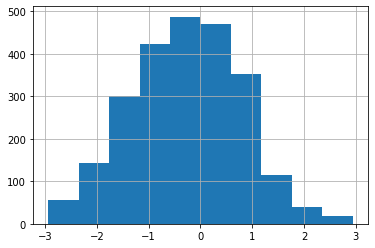

In [10]:
# Generate sparse matrix A matrix for mapping geno to geno_expand
from scipy.sparse import coo_matrix

line2num = dict(zip(line_names, range(len(line_names))))
row_idx, col_idx = np.arange(len(data)), np.array([line2num[line] for line in data.Linex])
A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))

# Turn block to dummy variables
data.block = data.block.astype("str")
block = pd.get_dummies(data.block).to_numpy()

y = data.ln_ci
y.hist()
plt.show()

In [11]:
sub = np.array([line in Focal_linetypes for line in data.LineType]) | np.array(data.LineType == 'G0') # pick subset of genotypes in Focal_linetypes
y = y[sub]
A = A.toarray()
A = A[sub]
block = block[sub]

### Define models

In [12]:
def define_models():
    
    global models
    
    with pm.Model() as model_flat:  
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        likelihood = Normal("y", mu = intercept +
                            pm.math.dot(block, block_effects), sigma=std, observed=y) # likelihood


    with pm.Model() as model_unif:
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu = pm.Normal('mu', mu=0, sigma=10)

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        mut_counts = np.sum(geno_array, 1)
        likelihood = Normal("likelihood", 
                            mu=intercept 
                            + mu*mut_counts 
                            + pm.math.dot(block, block_effects), 
                            sigma=std, observed=y)    

    with pm.Model() as model_neutral_unif:  
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu = pm.Normal('mu', sigma=10)
        q = pm.Beta('p', alpha=2, beta=2) # probability of mutation being non-neutral

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        w = pm.Bernoulli('w', p=q, shape=L)

        mut_effects = pm.Deterministic('mut_effects', mu*w)

        mut_counts = np.sum(geno_array, 1)

        likelihood = Normal("y", 
                            mu=intercept
                            + pm.math.dot(geno_array, mut_effects)
                            + pm.math.dot(block, block_effects), 
                            sigma=std, observed=y)    

    with pm.Model() as model_3_effects:  
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu1 = pm.HalfNormal('mu1', sigma=10)
        mu2 = pm.HalfNormal('mu2', sigma=10)
        q = pm.Beta('q', alpha=2, beta=2) # prob being non-neutral
        p = pm.Beta('p', alpha=2, beta=2) # prob being positive

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        z = pm.Bernoulli('z', p=q, shape=L) # 0/1 vector if locus is neutral
        w = pm.Bernoulli('w', p=p, shape=L) # 0/1 vector if locus is positive, conditional on being non-neutral    
        beta = pm.Deterministic('beta', z*(mu1*w - mu2*(1-w))) # mutational effects

        # Define likelihood
        likelihood = Normal("y", mu=intercept + pm.math.dot(geno_array, beta) + pm.math.dot(block, block_effects), sigma=std, observed=y)    

    with pm.Model() as model_neg_gamma:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for negative DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for negative DFE

        mut_effects = pm.Gamma("mut_effects", alpha=alpha1, beta=beta1, shape=L) #vector of negative mutation effects
        mut_effects_neg = pm.Deterministic("mut_effects_neg", -1*mut_effects) # total mutational effect
        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects_neg) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y)    


    with pm.Model() as model_1_gamma:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for positive DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for positive DFE
        p_pos = pm.Beta('p_pos', alpha=2, beta=2) # prob mutation being positive

        mut_effects_pos = pm.Gamma("mut_effects_pos", alpha=alpha1, beta=beta1, shape=L) #vector of positive mutation effects
        mut_effects_neg = pm.Gamma("mut_effects_neg", alpha=alpha1, beta=beta1, shape=L) #vector of negative mutation effects

        mask_pos = pm.Bernoulli("mask_pos", p=p_pos, shape=L) # mask for positive effects
        mask_neg = pm.Deterministic("mask_neg", mask_pos-1) # mask for negative effects    
        mut_effects = pm.Deterministic("mut_effects", mask_pos*mut_effects_pos + mask_neg*mut_effects_neg) # total mutational effect

        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y)    


    with pm.Model() as model_2_gammas:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for positive DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for positive DFE
        alpha2 = pm.HalfNormal("alpha2", sigma=10) #alpha param for negative DFE
        beta2 = pm.HalfNormal("beta2", sigma=10) #beta param for negative DFE
        p_pos = pm.Beta('p_pos', alpha=2, beta=2) # prob mutation being positive

        mut_effects_pos = pm.Gamma("mut_effects_pos", alpha=alpha1, beta=beta1, shape=L) #vector of positive mutation effects
        mut_effects_neg = pm.Gamma("mut_effects_neg", alpha=alpha2, beta=beta2, shape=L) #vector of negative mutation effects

        mask_pos = pm.Bernoulli("mask_pos", p=p_pos, shape=L) # mask for positive effects
        mask_neg = pm.Deterministic("mask_neg", mask_pos-1) # mask for negative effects    
        mut_effects = pm.Deterministic("mut_effects", mask_pos*mut_effects_pos + mask_neg*mut_effects_neg) # total mutational effect

        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y) # likelihood

    models = {"flat": model_flat, "unif": model_unif, "neu_unif": model_neutral_unif, 
              "3_effects": model_3_effects, "neg_gamma": model_neg_gamma,
              "1_gamma": model_1_gamma, "2_gammas": model_2_gammas}    

### Sample genotype replications

In [13]:
models_test = {"flat", "unif", "neg_gamma", "neu_unif", "3_effects", "1_gamma", "2_gammas"}

In [15]:
def geno_sample():
    # function for sampling genotypes from genotype probabilities predicted by MLM
    sample = (np.random.rand(*S_tensor.shape) < S_tensor).astype(float)
    return np.matmul(A, sample)

In [ ]:
# Specify the desired values for max_treedepth and target_accept
start_rep = 0

for i in range(start_rep, n_geno_reps):    
    geno_array = geno_sample()
    geno_name = "_".join(['geno_sample', str(i)])
    with open(sample_path +  geno_name + '.pkl', 'wb') as file:  
        pickle.dump(geno_array, file)
        
    define_models()
    
    for model_name in models_test:
        print(f"working on replicate {i}, model {model_name}")
        model = models[model_name]
        with model:
            traces = sample(n_sample)
        trace_name = "_".join(['traces', model_name, str(i)])
        with open(sample_path + trace_name +  '.pkl', 'wb') as file:  
            pickle.dump(traces, file)    

working on replicate 0, model 2_gammas


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, alpha2, beta2, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 3122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 0, model unif


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, mu, block_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 248 seconds.


working on replicate 0, model neu_unif


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu, p, block_effects]
>BinaryGibbsMetropolis: [w]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 843 seconds.
/home/juannanzhou/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


working on replicate 0, model neg_gamma


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, block_effects, alpha1, beta1, mut_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4219 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2718 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


working on replicate 0, model 1_gamma


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1942 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 0, model flat


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, block_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 157 seconds.


working on replicate 0, model 3_effects


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu1, mu2, q, p, block_effects]
>BinaryGibbsMetropolis: [z, w]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1638 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 383 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 1, model 2_gammas


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, alpha2, beta2, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2629 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 1, model unif


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, mu, block_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 252 seconds.


working on replicate 1, model neu_unif


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu, p, block_effects]
>BinaryGibbsMetropolis: [w]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 856 seconds.
/home/juannanzhou/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


working on replicate 1, model neg_gamma


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, block_effects, alpha1, beta1, mut_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4245 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3742 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


working on replicate 1, model 1_gamma


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

working on replicate 2, model unif


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, mu, block_effects]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

working on replicate 3, model neu_unif


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu, p, block_effects]
>BinaryGibbsMetropolis: [w]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

working on replicate 3, model 1_gamma


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1735 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for

working on replicate 3, model flat


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, block_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 163 seconds.


working on replicate 3, model 3_effects


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu1, mu2, q, p, block_effects]
>BinaryGibbsMetropolis: [z, w]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

working on replicate 5, model 2_gammas


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, alpha2, beta2, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2169 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 5, model unif


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, std, mu, block_effects]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 176 seconds.


working on replicate 5, model 3_effects


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, mu1, mu2, q, p, block_effects]
>BinaryGibbsMetropolis: [z, w]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1723 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


working on replicate 6, model 2_gammas


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, std, block_effects, alpha1, beta1, alpha2, beta2, p_pos, mut_effects_pos, mut_effects_neg]
>BinaryGibbsMetropolis: [mask_pos]
